In [1]:
%%capture
!pip install --upgrade pip
!pip3 install --upgrade pip
!pip install opencv-rolling-ball
!pip install tifffile
!pip install tifffile --user
!pip3 install tifffile
!pip3 install tifffile --user
!sudo python3 -m pip install tifffile
import sys
sys.path.append('/home/ec2-user/.local/bin')

In [2]:
%%time
import sagemaker
from sagemaker import get_execution_role
from IPython.core.debugger import set_trace
role = get_execution_role()
print(role)
sess = sagemaker.Session()

arn:aws:iam::102554356212:role/service-role/AmazonSageMaker-ExecutionRole-20181129T100657
CPU times: user 922 ms, sys: 373 ms, total: 1.3 s
Wall time: 952 ms


In [3]:
bucket = sess.default_bucket()  
prefix = 'fresh_train_trial'
print(bucket)

sagemaker-eu-west-1-102554356212


In [4]:
from sagemaker.amazon.amazon_estimator import get_image_uri
training_image = get_image_uri(sess.boto_region_name, 'semantic-segmentation', repo_version="latest")
print (training_image)

685385470294.dkr.ecr.eu-west-1.amazonaws.com/semantic-segmentation:latest


### Setup data

In [5]:
import os
import shutil

# Create directory structure mimicing the s3 bucket where data is to be dumped.
lf8 = '/home/ec2-user/SageMaker/raw_data/lior_figure_eight'
os.makedirs(os.path.join(lf8,'train'), exist_ok=True)
os.makedirs(os.path.join(lf8,'validation'), exist_ok=True)
os.makedirs(os.path.join(lf8,'train_annotation'), exist_ok=True)
os.makedirs(os.path.join(lf8,'validation_annotation'), exist_ok=True)

train_channel = prefix + '/train'
validation_channel = prefix + '/validation'
train_annotation_channel = prefix + '/train_annotation'
validation_annotation_channel = prefix + '/validation_annotation'

Consider copying labeled data from Lior (MaskRCNN labels): gs://segproj/liorresults are the masks
Also try getting Usigacii raw data


## Prepare Figure8 Ground Truth

In [ ]:
%%capture
#figure8
import boto3
import numpy as np
from skimage import util 
from skimage.util import img_as_ubyte
from skimage import exposure
from skimage.io import imread as pngread
from skimage.io import imsave as pngsave
from tifffile import imsave,imread
import cv2
from rolling_ball_filter import rolling_ball_filter
from scipy import ndimage 
from skimage import morphology
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage.segmentation import mark_boundaries
from skimage import color
from skimage import img_as_int

# Copy tif from s3 to local sagemaker
files = []
s3 = boto3.resource('s3')
s3_resource = boto3.resource('s3')
s3meadata = s3_resource.Bucket(name='meadata')

for obj in s3meadata.objects.all():
    if 'tif' in obj.key:
        file = obj.key
        if 'segproj/training_data/train/' in obj.key:
            s3.meta.client.download_file('meadata', file, '/tmp/raw.tif')
            inverted_img = util.invert(imread('/tmp/raw.tif'))
            jpgpath = '/tmp/'+'fig8_'+file.split('/')[-2]+'_'+'raw.jpg'
            num = int(''.join(filter(str.isdigit, str(inverted_img.dtype)))) - 1
            image = exposure.rescale_intensity(inverted_img, out_range=(0, 2**num - 1))
            imsave(jpgpath,img_as_ubyte(image))
            sess.upload_data(path=jpgpath, bucket=bucket, key_prefix=train_channel)
        elif 'segproj/training_data/val/' in obj.key:
            s3.meta.client.download_file('meadata', file, '/tmp/raw.tif')
            inverted_img = util.invert(imread('/tmp/raw.tif'))
            jpgpath = '/tmp/'+'fig8_'+file.split('/')[-2]+'_'+'raw.jpg'
            num = int(''.join(filter(str.isdigit, str(inverted_img.dtype)))) - 1
            image = exposure.rescale_intensity(inverted_img, out_range=(0, 2**num - 1))
            imsave(jpgpath,img_as_ubyte(image))
            sess.upload_data(path=jpgpath, bucket=bucket, key_prefix=validation_channel)
    elif 'instances_ids.png' in obj.key:
        file = obj.key
        if 'segproj/training_data/train/' in obj.key:
            s3.meta.client.download_file('meadata', file, '/tmp/instances_ids.png')
            pngpath = '/tmp/'+'fig8_'+file.split('/')[-2]+'_'+'raw.png'
            im1 = pngread('/tmp/instances_ids.png')
            num = int(''.join(filter(str.isdigit, str(im1.dtype)))) - 1
            image = exposure.rescale_intensity(im1, out_range=(0, 2**num - 1))
            image = img_as_ubyte(image)
            im = mark_boundaries(image, im1, color = [0,0,0], outline_color = [0,0,0], mode='outer', background_label=0)
            im2 = exposure.rescale_intensity(color.rgb2gray(im), out_range=(-1, 1))
            im2 = img_as_int(im2)
            im3 = exposure.rescale_intensity(np.uint32(im2), out_range=(2**15 - 1,0))
            im3 = np.uint8(im3)
            im3[im3<=254]=0
            im3[im3>254]=1
            im =  cv2.resize(im3, (1024,1024), interpolation = cv2.INTER_AREA)            
            pngsave(pngpath,np.uint8(im), check_contrast=False)
            sess.upload_data(path=pngpath, bucket=bucket, key_prefix=train_annotation_channel)
        elif 'segproj/training_data/val/' in obj.key:
            s3.meta.client.download_file('meadata', file, '/tmp/instances_ids.png')
            pngpath = '/tmp/'+'fig8_'+file.split('/')[-2]+'_'+'raw.png'
            im1 = pngread('/tmp/instances_ids.png')
            num = int(''.join(filter(str.isdigit, str(im1.dtype)))) - 1
            image = exposure.rescale_intensity(im1, out_range=(0, 2**num - 1))
            image = img_as_ubyte(image)
            im = mark_boundaries(image, im1, color = [0,0,0], outline_color = [0,0,0], mode='outer', background_label=0)
            im2 = exposure.rescale_intensity(color.rgb2gray(im), out_range=(-1, 1))
            im2 = img_as_int(im2)
            im3 = exposure.rescale_intensity(np.uint32(im2), out_range=(2**15 - 1,0))
            im3 = np.uint8(im3)
            im3[im3<=254]=0
            im3[im3>254]=1
            im =  cv2.resize(im3, (1024,1024), interpolation = cv2.INTER_AREA)            
            pngsave(pngpath,np.uint8(im), check_contrast=False)
            sess.upload_data(path=pngpath, bucket=bucket, key_prefix=validation_annotation_channel)

## Prepare Usiigaci Ground Truth (phase contrast)

In [ ]:
%%capture
#usiigaci
import boto3
import numpy as np
from skimage import util 
from skimage.util import img_as_ubyte
from skimage import exposure
from skimage.io import imread as pngread
from skimage.io import imsave as pngsave
from tifffile import imsave,imread
import cv2
from rolling_ball_filter import rolling_ball_filter
import random
import threading
from skimage.segmentation import mark_boundaries
from skimage import color
files = []
s3 = boto3.resource('s3')
s3_resource = boto3.resource('s3')
s3meadata = s3_resource.Bucket(name='meadata')

def proccessusiigacifiles(f, s3 = s3, sess = sess, bucket = bucket, prefix = prefix):
    train_channel = prefix + '/train'
    validation_channel = prefix + '/validation'
    train_annotation_channel = prefix + '/train_annotation'
    validation_annotation_channel = prefix + '/validation_annotation'
    if 'tif' in f:
        ranNUM = random.randint(0,1000000)
        file = f
        if 'segproj/usiigaci_train_data/train/' in f:
            s3.meta.client.download_file('meadata', file, '/tmp/raw'+str(ranNUM)+'.tif')
            inverted_img = util.invert(imread('/tmp/raw'+str(ranNUM)+'.tif'))
            jpgpath = '/tmp/'+'usiigaci_'+file.split('/')[-2]+'_'+'raw.jpg'
            num = int(''.join(filter(str.isdigit, str(inverted_img.dtype)))) - 1
            image = exposure.rescale_intensity(inverted_img, out_range=(0, 2**num - 1))
            image =  cv2.resize(img_as_ubyte(image), (1024,1024), interpolation = cv2.INTER_AREA)
            image,_ = rolling_ball_filter(image, ball_radius = 20, spacing = 1, top=False)
            imsave(jpgpath,image)
            sess.upload_data(path=jpgpath, bucket=bucket, key_prefix=train_channel)
        elif 'segproj/usiigaci_train_data/val/' in f:
            s3.meta.client.download_file('meadata', file, '/tmp/raw'+str(ranNUM)+'.tif')
            inverted_img = util.invert(imread('/tmp/raw'+str(ranNUM)+'.tif'))
            jpgpath = '/tmp/'+'usiigaci_'+file.split('/')[-2]+'_'+'raw.jpg'
            num = int(''.join(filter(str.isdigit, str(inverted_img.dtype)))) - 1
            image = exposure.rescale_intensity(inverted_img, out_range=(0, 2**num - 1))
            image =  cv2.resize(img_as_ubyte(image), (1024,1024), interpolation = cv2.INTER_AREA)
            image,_ = rolling_ball_filter(image, ball_radius = 20, spacing = 1, top=False)
            imsave(jpgpath,image)
            sess.upload_data(path=jpgpath, bucket=bucket, key_prefix=validation_channel)
    elif 'instances_ids.png' in f:
        ranNUM = random.randint(0,1000000)
        file = f
        if 'segproj/usiigaci_train_data/train/' in f:
            s3.meta.client.download_file('meadata', file, '/tmp/instances_ids'+str(ranNUM)+'.png')
            pngpath = '/tmp/'+'usiigaci_'+file.split('/')[-2]+'_'+'raw.png'
            im1 = pngread('/tmp/instances_ids'+str(ranNUM)+'.png')
            num = int(''.join(filter(str.isdigit, str(im1.dtype)))) - 1
            image = exposure.rescale_intensity(im1, out_range=(0, 2**num - 1))
            image = img_as_ubyte(image)
            im = mark_boundaries(image, im1, color = [0,0,0], outline_color = [0,0,0], mode='outer', background_label=0)
            im2 = exposure.rescale_intensity(color.rgb2gray(im), out_range=(-1, 1))
            im2 = img_as_int(im2)
            im3 = exposure.rescale_intensity(np.uint32(im2), out_range=(2**15 - 1,0))
            im3 = np.uint8(im3)
            im3[im3<=254]=0
            im3[im3>254]=1
            im =  cv2.resize(im3, (1024,1024), interpolation = cv2.INTER_AREA)            
            pngsave(pngpath,np.uint8(im), check_contrast=False)
            sess.upload_data(path=pngpath, bucket=bucket, key_prefix=train_annotation_channel)
        elif 'segproj/usiigaci_train_data/val/' in f:
            s3.meta.client.download_file('meadata', file, '/tmp/instances_ids'+str(ranNUM)+'.png')
            pngpath = '/tmp/'+'usiigaci_'+file.split('/')[-2]+'_'+'raw.png'
            im1 = pngread('/tmp/instances_ids'+str(ranNUM)+'.png')
            num = int(''.join(filter(str.isdigit, str(im1.dtype)))) - 1
            image = exposure.rescale_intensity(im1, out_range=(0, 2**num - 1))
            image = img_as_ubyte(image)
            im = mark_boundaries(image, im1, color = [0,0,0], outline_color = [0,0,0], mode='outer', background_label=0)
            im2 = exposure.rescale_intensity(color.rgb2gray(im), out_range=(-1, 1))
            im2 = img_as_int(im2)
            im3 = exposure.rescale_intensity(np.uint32(im2), out_range=(2**15 - 1,0))
            im3 = np.uint8(im3)
            im3[im3<=254]=0
            im3[im3>254]=1
            im =  cv2.resize(im3, (1024,1024), interpolation = cv2.INTER_AREA)            
            pngsave(pngpath,np.uint8(im), check_contrast=False)
            sess.upload_data(path=pngpath, bucket=bucket, key_prefix=validation_annotation_channel)
    
            
keys = [obj.key for obj in s3meadata.objects.all()]
for key in keys:
    t = threading.Thread(target = proccessusiigacifiles, args=(key,)).start()

## Prepare Lior's Ground Truth (manually adjusted MaskRCNN)

In [ ]:
%%capture
def proccessliorfiles(f, s3 = s3, sess = sess, bucket = bucket, prefix = prefix):
    train_channel = prefix + '/train'
    validation_channel = prefix + '/validation'
    train_annotation_channel = prefix + '/train_annotation'
    validation_annotation_channel = prefix + '/validation_annotation'
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    if 'tif' in f:
        ranNUM = random.randint(0,1000000)
        file = f
        file = file.replace('._','')
        if 'segproj/liorp_training_data/train/' in f:
            s3.meta.client.download_file('meadata', file, '/tmp/raw'+str(ranNUM)+'.tif')
            image = imread('/tmp/raw'+str(ranNUM)+'.tif')
            image = clahe.apply(image)
            image =  cv2.resize(image, (1024,1024), interpolation = cv2.INTER_AREA)
            inverted_img,_ = rolling_ball_filter(image, ball_radius = 20, spacing = 1, top=False)
            jpgpath = '/tmp/'+'liorp_'+file.split('/')[-2]+'_'+'raw.jpg'
            num = int(''.join(filter(str.isdigit, str(inverted_img.dtype)))) - 1
            image = exposure.rescale_intensity(inverted_img, out_range=(0, 2**num - 1))
            imsave(jpgpath,img_as_ubyte(image))
            sess.upload_data(path=jpgpath, bucket=bucket, key_prefix=train_channel)
        elif 'segproj/liorp_training_data/val/' in f:
            s3.meta.client.download_file('meadata', file, '/tmp/raw'+str(ranNUM)+'.tif')
            image = imread('/tmp/raw'+str(ranNUM)+'.tif')
            image = clahe.apply(image)
            image =  cv2.resize(image, (1024,1024), interpolation = cv2.INTER_AREA)
            inverted_img,_ = rolling_ball_filter(image, ball_radius = 20, spacing = 1, top=False)
            jpgpath = '/tmp/'+'liorp_'+file.split('/')[-2]+'_'+'raw.jpg'
            num = int(''.join(filter(str.isdigit, str(inverted_img.dtype)))) - 1
            image = exposure.rescale_intensity(inverted_img, out_range=(0, 2**num - 1))
            imsave(jpgpath,img_as_ubyte(image))
            sess.upload_data(path=jpgpath, bucket=bucket, key_prefix=validation_channel)
    elif 'instances_ids.png' in f:
        ranNUM = random.randint(0,1000000)
        file = f
        file = file.replace('._','')
        if 'segproj/liorp_training_data/train/' in f:
            s3.meta.client.download_file('meadata', file, '/tmp/instances_ids'+str(ranNUM)+'.png')
            pngpath = '/tmp/'+'liorp_'+file.split('/')[-2]+'_'+'raw.png'
            im1 = pngread('/tmp/instances_ids'+str(ranNUM)+'.png')
            num = int(''.join(filter(str.isdigit, str(im1.dtype)))) - 1
            image = exposure.rescale_intensity(im1, out_range=(0, 2**num - 1))
            image = img_as_ubyte(image)
            im = mark_boundaries(image, im1, color = [0,0,0], outline_color = [0,0,0], mode='outer', background_label=0)
            im2 = exposure.rescale_intensity(color.rgb2gray(im), out_range=(-1, 1))
            im2 = img_as_int(im2)
            im3 = exposure.rescale_intensity(np.uint32(im2), out_range=(2**15 - 1,0))
            im3 = np.uint8(im3)
            im3[im3<=254]=0
            im3[im3>254]=1
            im =  cv2.resize(im3, (1024,1024), interpolation = cv2.INTER_AREA)            
            pngsave(pngpath,np.uint8(im), check_contrast=False)
            sess.upload_data(path=pngpath, bucket=bucket, key_prefix=train_annotation_channel)
        elif 'segproj/liorp_training_data/val/' in f:
            s3.meta.client.download_file('meadata', file, '/tmp/instances_ids'+str(ranNUM)+'.png')
            pngpath = '/tmp/'+'liorp_'+file.split('/')[-2]+'_'+'raw.png'
            im1 = pngread('/tmp/instances_ids'+str(ranNUM)+'.png')
            num = int(''.join(filter(str.isdigit, str(im1.dtype)))) - 1
            image = exposure.rescale_intensity(im1, out_range=(0, 2**num - 1))
            image = img_as_ubyte(image)
            im = mark_boundaries(image, im1, color = [0,0,0], outline_color = [0,0,0], mode='outer', background_label=0)
            im2 = exposure.rescale_intensity(color.rgb2gray(im), out_range=(-1, 1))
            im2 = img_as_int(im2)
            im3 = exposure.rescale_intensity(np.uint32(im2), out_range=(2**15 - 1,0))
            im3 = np.uint8(im3)
            im3[im3<=254]=0
            im3[im3>254]=1
            im =  cv2.resize(im3, (1024,1024), interpolation = cv2.INTER_AREA)            
            pngsave(pngpath,np.uint8(im), check_contrast=False)
            sess.upload_data(path=pngpath, bucket=bucket, key_prefix=validation_annotation_channel)

keys = [obj.key for obj in s3meadata.objects.all()]
for key in keys:
    t = threading.Thread(target = proccessliorfiles, args=(key,)).start()


In [8]:
import json
label_map = { "scale": 1 }
with open('train_label_map.json', 'w') as lm_fname:
    json.dump(label_map, lm_fname)

In [9]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)
print(s3_output_location)

s3://sagemaker-eu-west-1-102554356212/fresh_train_trial/output


## Training

In [10]:
# Create the sagemaker estimator object.
ss_model = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count = 1, 
                                         train_instance_type = 'ml.p3.16xlarge',
                                         train_volume_size = 150, # size in gb on s3 to reserve
                                         train_max_run = 360000,
                                         output_path = s3_output_location,
                                         base_job_name = 'fresh-train-trial',
                                         sagemaker_session = sess)

In [11]:
# Setup hyperparameters 
ss_model.set_hyperparameters(backbone='resnet-50', # This is the encoder. Other option is resnet-101
                             algorithm='deeplab', # This is the decoder. Other option is 'psp' and 'deeplab'                             
                             use_pretrained_model='True', # Use the pre-trained model.
                             crop_size=240, # Size of image random crop.                             
                             num_classes=2, # Background + cell 
                             epochs=500, # Number of epochs to run.
                             learning_rate=0.0001,                             
                             optimizer='rmsprop', # Other options include 'adam', 'rmsprop', 'nag', 'adagrad'.
                             lr_scheduler='poly', # Other options include 'cosine' and 'step'.                           
                             mini_batch_size=16, # Setup some mini batch size.
                             validation_mini_batch_size=16, #try larger batch sizes maybe? 
                             early_stopping=True, # Turn on early stopping. If OFF, other early stopping parameters are ignored.
                             early_stopping_patience=20, # Tolerate these many epochs if the mIoU doens't increase.
                             early_stopping_min_epochs=10, # No matter what, run these many number of epochs.                             
                             num_training_samples=345,
                             initialize_last_layer=False,
                             last_layers_contain_logits_only=False) 

In [12]:
# Create full bucket names
s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)
s3_train_annotation = 's3://{}/{}'.format(bucket, train_annotation_channel)
s3_validation_annotation = 's3://{}/{}'.format(bucket, validation_annotation_channel)

distribution = 'FullyReplicated'
# Create sagemaker s3_input objects
train_data = sagemaker.session.s3_input(s3_train_data, distribution=distribution, 
                                        content_type='image/jpeg', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution=distribution, 
                                        content_type='image/jpeg', s3_data_type='S3Prefix')
train_annotation = sagemaker.session.s3_input(s3_train_annotation, distribution=distribution, 
                                        content_type='image/png', s3_data_type='S3Prefix')
validation_annotation = sagemaker.session.s3_input(s3_validation_annotation, distribution=distribution, 
                                        content_type='image/png', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 
                 'validation': validation_data,
                 'train_annotation': train_annotation, 
                 'validation_annotation':validation_annotation}

In [ ]:
%%capture
ss_model.fit(inputs=data_channels, logs=True)

In [ ]:
# #HyperParam Optimization
# !pip3 install smac

# from smac.configspace import ConfigurationSpace
# from ConfigSpace.hyperparameters import CategoricalHyperparameter, UniformFloatHyperparameter, UniformIntegerHyperparameter

# cs = ConfigurationSpace()

# backbone = CategoricalHyperparameter("backbone", ['resnet-50','resnet-101'], default_value="resnet-50")
# algorithm = CategoricalHyperparameter("algorithm", ['psp','deeplab'], default_value="deeplab")
# lr_scheduler = CategoricalHyperparameter("lr_scheduler", ['poly','cosine','step'], default_value="poly")
# optimizer = CategoricalHyperparameter("optimizer", ['resnet-50','resnet-101'], default_value="resnet-50")
# use_pretrained_model = CategoricalHyperparameter("use_pretrained_model", ['False','True'], default_value="True")

# crop_size = UniformIntegerHyperparameter("crop_size", 64,512, default_value=240)
# early_stopping_min_epochs = UniformIntegerHyperparameter("early_stopping_min_epochs", 10,60, default_value=10)
# early_stopping_patience = UniformIntegerHyperparameter("early_stopping_patience", 2,20, default_value=5)
# epochs = UniformIntegerHyperparameter("epochs", 10,1000, default_value=100)
# mini_batch_size = UniformIntegerHyperparameter("mini_batch_size", 8,56, default_value=16)
# validation_mini_batch_size = UniformIntegerHyperparameter("validation_mini_batch_size", 8,48, default_value=16)
# early_stopping_patience = UniformIntegerHyperparameter("early_stopping_patience", 10,50, default_value=20)
# early_stopping_min_epochs = UniformIntegerHyperparameter("early_stopping_min_epochs", 10,50, default_value=10)

# learning_rate = UniformFloatHyperparameter("learning_rate", 0.0001,0.1, default_value=0.0001)


# cs.add_hyperparameter([backbone,algorithm,lr_scheduler,optimizer,use_pretrained_model,
#                        crop_size, early_stopping_min_epochs, early_stopping_patience,
#                        epochs, mini_batch_size, validation_mini_batch_size, early_stopping_patience, early_stopping_min_epochs])

# def ssmodel_from_cfg(cfg):

#     ss_model.fit(inputs=data_channels, logs=True)

#     score = model_result
#     return 1-score 


# from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
# paramdict = {'backbone' :   CategoricalParameter(['resnet-50','resnet-101']),
#              'algorithm': CategoricalParameter(['psp','deeplab']),
#             'crop_size' :   IntegerParameter(64,512),
#             'early_stopping_min_epochs':    IntegerParameter(10,60),
#             'early_stopping_patience':    IntegerParameter(2,20),
#             'epochs' :   IntegerParameter(10,1000),
#             'learning_rate':    ContinuousParameter(0.0001, 0.1),
#             'lr_scheduler':    CategoricalParameter(['poly','cosine','step']),
#             'optimizer' :   CategoricalParameter(['rmsprop','adam','nag', 'adagrad']),
#             'use_pretrained_model'  :  CategoricalParameter([False,True]),
#             'mini_batch_size': IntegerParameter(8,48), 
#             'validation_mini_batch_size':IntegerParameter(8,48),
#             'early_stopping_patience': IntegerParameter(10,50), 
#             'early_stopping_min_epochs':IntegerParameter(10,50)}
# momentum = 0.9, 
# weight_decay = 0.0001

# objective_metric_name = 'validation mIOU'
# # metric_definitions = [{'Name': 'validation mIOU',
# #                        'Regex': 'validation mIOU=([0-9\\.]+)'}]

# tuner = HyperparameterTuner(ss_model,
#                             objective_metric_name,
#                             paramdict,
#                             max_jobs=100,
#                             max_parallel_jobs=2)

# tuner.fit(inputs=data_channels)
# bayes_metrics = sagemaker.HyperparameterTuningJobAnalytics(tuner._current_job_name).dataframe()
# bayes_metrics.sort_values(['FinalObjectiveValue'], ascending=False)

In [13]:
ss_predictor = ss_model.deploy(initial_instance_count=1, instance_type='ml.c4.xlarge')

ValueError: Estimator is not associated with a training job

## Inference

Let us convert the image to bytearray before we supply it to our endpoint.

/home/ec2-user/SageMaker/Segment2P/rolling_ball_filter.py:40: RuntimeWarning: invalid value encountered in sqrt
  structure = 2 * np.sqrt(1 - ((mesh / radius.reshape(-1, *((1,) * ndim)))**2).sum(0))
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from uint16 to uint8
  .format(dtypeobj_in, dtypeobj_out))


(-0.5, 255.5, 255.5, -0.5)

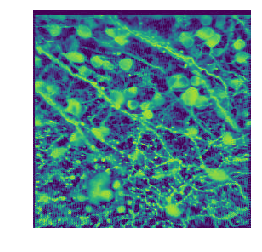

In [20]:
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import io
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
# images/liorp_181106_2_raw.jpg
# filename = "/home/ec2-user/SageMaker/images/190128_LD2_cleaned_ver1.tif"
filename = "/home/ec2-user/SageMaker/images/liorp_181106_2_raw.jpg"
# im = pngread(filename)
# im = clahe.apply(im)
im,_ = rolling_ball_filter(im, ball_radius = 20, spacing = 1, top=False)
im =  cv2.resize(im, (256,256), interpolation = cv2.INTER_AREA)
num = int(''.join(filter(str.isdigit, str(im.dtype)))) - 1
im = img_as_ubyte(exposure.rescale_intensity(im, out_range=(0, 2**num - 1)))
pngsave(filename.replace('tif','jpg'), im)

with open(filename.replace('tif','jpg'), 'rb') as image:
    img = image.read()    
    img = bytearray(img)

plt.imshow(Image.open(io.BytesIO(img)))
plt.axis('off')

In [ ]:
%%time 
ss_predictor.content_type = 'image/jpeg'
ss_predictor.accept = 'image/png'
return_img = ss_predictor.predict(img)

Let us display the segmentation mask.

In [ ]:
from PIL import Image
import numpy as np
import io

num_classes = 2
mask = np.array(Image.open(io.BytesIO(return_img)))
plt.imshow(mask)
plt.show()

In [ ]:
from scipy import ndimage 
from skimage import morphology
from skimage.morphology import watershed
from skimage.feature import peak_local_max
distance = ndimage.distance_transform_edt(mask)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)), labels=mask)
markers = morphology.label(local_maxi)
labels_ws = watershed(-distance, markers, mask=mask,watershed_line=True)
plt.imshow(labels_ws>0)
plt.show()

## Delete the Endpoint
Having an endpoint running will incur some costs. Therefore as a clean-up job, we should delete the endpoint.

In [ ]:
sagemaker.Session().delete_endpoint(ss_predictor.endpoint)

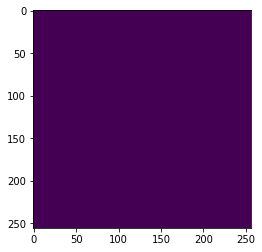

In [21]:
# import boto3
# import json
# from sagemaker.amazon.record_pb2 import Record
# import mxnet as mx
# from PIL import Image
# import numpy as np
# import io

# endpoint = "fresh-train-trial-2019-07-16-12-00-41-881"
 
# runtime = boto3.Session().client('sagemaker-runtime')
 
# # Read image into memory
# # Send image via InvokeEndpoint API
# response = runtime.invoke_endpoint(EndpointName=endpoint, ContentType='image/jpeg', Accept = 'image/png', Body=img)
# a = response['Body'].read()
# mask = np.array(Image.open(io.BytesIO(a)))
# plt.imshow(mask)
# plt.show()

In [22]:
# sagemaker.Session().delete_endpoint(endpoint)